In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Summary ClinVar and ACMG variant analysis</h2>

In [3]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


In [4]:
#Add native APADB isoform abundance measurements
apadb_df = pd.read_csv('../data/native_data/apadb/unprocessed_data/hg19.apadb_v2_final.bed', names=['chr', 'start', 'end', 'gene', 'reads', 'strand', 'site_type', 'cut_mean', 'cut_mode', 'mir'], sep='\t')

apadb_variant_df, apadb_variant_df_filtered = append_apadb_isoform_usage(apadb_df, human_variant_df, human_variant_df_filtered)


All human variants


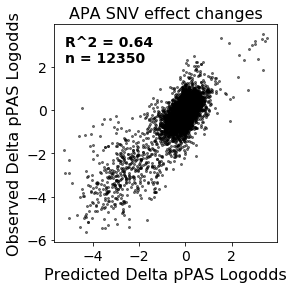

All human variants with significant measured effects


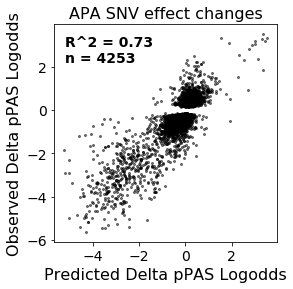

In [10]:
df_to_use = human_variant_df_filtered

save_figs = False

pred_column = 'mean_delta_logodds_pred'
true_column = 'delta_logodds_true'

print("All human variants")

r_val, _ = pearsonr(df_to_use[pred_column], df_to_use[true_column])

f = plt.figure(figsize=(4, 4))

plt.scatter(df_to_use[pred_column], df_to_use[true_column], alpha=0.5, s=4, c='black')

annot_text = 'R^2 = ' + str(round(r_val * r_val, 2))
annot_text += '\nn = ' + str(len(df_to_use))
ax = plt.gca()
ax.text(0.05, 0.95, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted Delta pPAS Logodds', fontsize=16)
plt.ylabel('Observed Delta pPAS Logodds', fontsize=16)
plt.title('APA SNV effect changes', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('delta_usage_pred_vs_true_all.png', dpi=150, transparent=True)
    plt.savefig('delta_usage_pred_vs_true_all.eps')

plt.show()

print("All human variants with significant measured effects")

df_to_use = human_variant_df_filtered.query("delta_p_val < 0.0001")

r_val, _ = pearsonr(df_to_use[pred_column], df_to_use[true_column])

f = plt.figure(figsize=(4, 4))

plt.scatter(df_to_use[pred_column], df_to_use[true_column], alpha=0.5, s=4, c='black')

annot_text = 'R^2 = ' + str(round(r_val * r_val, 2))
annot_text += '\nn = ' + str(len(df_to_use))
ax = plt.gca()
ax.text(0.05, 0.95, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted Delta pPAS Logodds', fontsize=16)
plt.ylabel('Observed Delta pPAS Logodds', fontsize=16)
plt.title('APA SNV effect changes', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('delta_usage_pred_vs_true_significant.png', dpi=150, transparent=True)
    plt.savefig('delta_usage_pred_vs_true_significant.eps')

plt.show()


All human variants


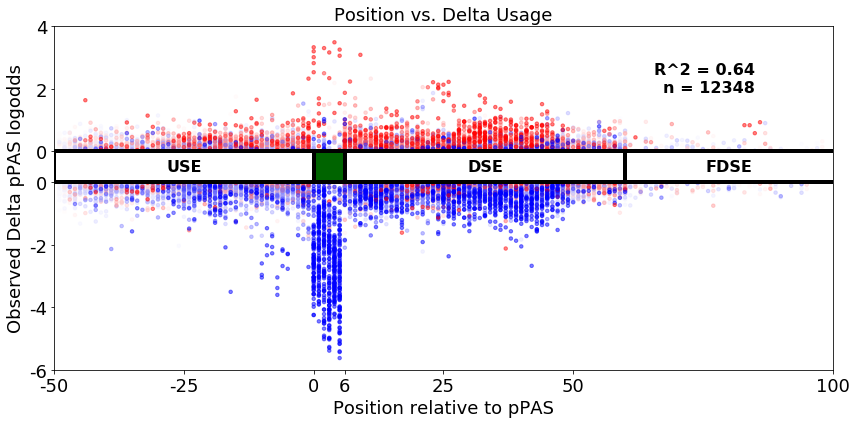

All human variants with predicted log fold change >= 0.1


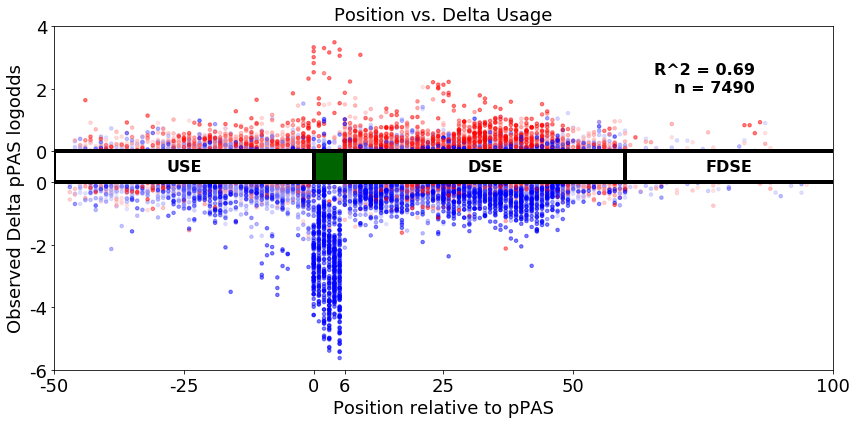

Pathogenic ClinVar variants


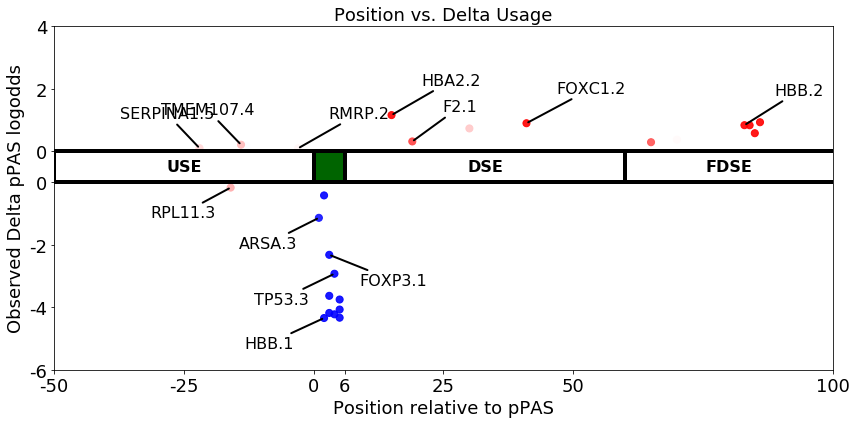

Conflicting ClinVar variants


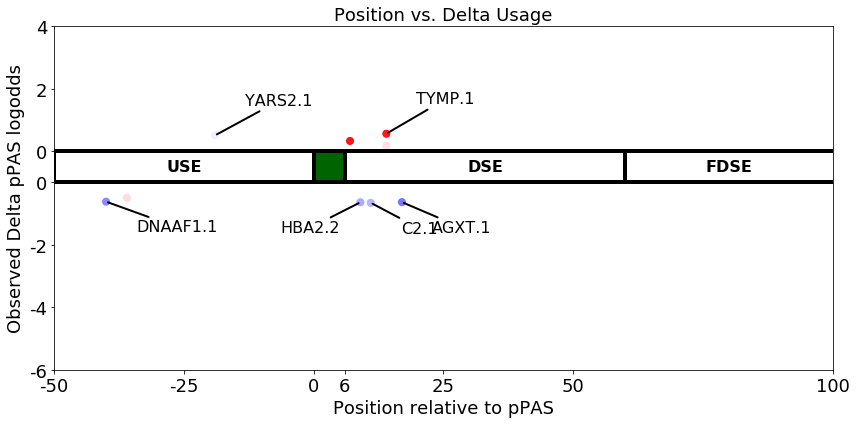

In [9]:

save_figs = False

#All variants
print("All human variants")
df_to_use = human_variant_df_filtered

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, pred_column=['mean_delta_logodds_pred'], min_pred_filter=0.0, figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)



#Filtered on prediction >= 0.1 (log)
print("All human variants with predicted log fold change >= 0.1")
df_to_use = human_variant_df_filtered

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_01'
plot_position_delta_scatter(df_to_use, pred_column=['mean_delta_logodds_pred'], min_pred_filter=0.1, figsize=figsize, fig_name=fig_name, vmin=-0.5, vmax=0.5, fig_dpi=150, annotate=None)


#Annotate pathogenic variants
print("Pathogenic ClinVar variants")
bg_df = human_variant_df_filtered

pathogenic_df = human_variant_df.query("significance == 'Pathogenic'")

gene_blacklist = [('RNU4ATAC.4', 200.0), ('HBB.3', 200), ('HBB.4', 200)]

keep_index = []
for index, row in pathogenic_df.iterrows() :
    blacklisted = False
    
    for filter_gene, filter_pos in gene_blacklist :
        if row['gene'] == filter_gene and row['snv_pos'] < filter_pos :
            blacklisted = True
    
    if not blacklisted :
        keep_index.append(index)

pathogenic_df = pathogenic_df.loc[keep_index]

annotate = {
    'annotate_right_list' : ['F2.1', 'FOXC1.2', 'RMRP.2', 'HBB.2', 'HBA2.2'],
    'annotate_right_down_list' : ['FOXP3.1', 'RNU4ATAC.4'],
    'annotate_left_list' : ['HBB.3', 'HBB.4', 'TMEM107.4', 'SERPINA1.5'],
    'annotate_left_down_list' : ['HBB.1', 'TP53.3', 'ARSA.3', 'RPL11.3']
}

fig_name = None
if save_figs :
    fig_name = 'position_delta_pathogenic'
plot_position_delta_scatter(pathogenic_df, pred_column=['mean_delta_logodds_pred'], min_pred_filter=0.0, figsize=figsize, dot_size=50, dot_alpha=0.9, vmin=-0.5, vmax=0.45, show_stats=False, fig_name=fig_name, fig_dpi=150, annotate=annotate, bg_df=None)


#Annotate conflicting variants, stat. significant only
print("Conflicting ClinVar variants")
bg_df = human_variant_df_filtered

conflicting_df = human_variant_df.query("significance == 'Conflicting' and delta_p_val < 0.05")

gene_blacklist = []
keep_index = []
for index, row in conflicting_df.iterrows() :
    blacklisted = False
    
    for filter_gene, filter_pos in gene_blacklist :
        if row['gene'] == filter_gene and row['snv_pos'] < filter_pos :
            blacklisted = True
    
    if not blacklisted :
        keep_index.append(index)

conflicting_df = conflicting_df.loc[keep_index]

annotate = {
    'annotate_right_list' : ['TYMP.1', 'TAF1C.1', 'YARS2.1'],
    'annotate_right_down_list' : ['C2.1', 'AGXT.1', 'DNAAF1.1'],
    'annotate_left_list' : ['APRT.2'],
    'annotate_left_down_list' : ['HBA2.2', 'MOCS2.6', 'GYS1.3']
}

fig_name = None
if save_figs :
    fig_name = 'position_delta_conflicting_significant'
plot_position_delta_scatter(conflicting_df, pred_column=['mean_delta_logodds_pred'], min_pred_filter=0.0, figsize=figsize, dot_size=50, dot_alpha=0.9, vmin=-0.5, vmax=0.5, show_stats=False, fig_name=fig_name, fig_dpi=150, annotate=annotate, bg_df=None)


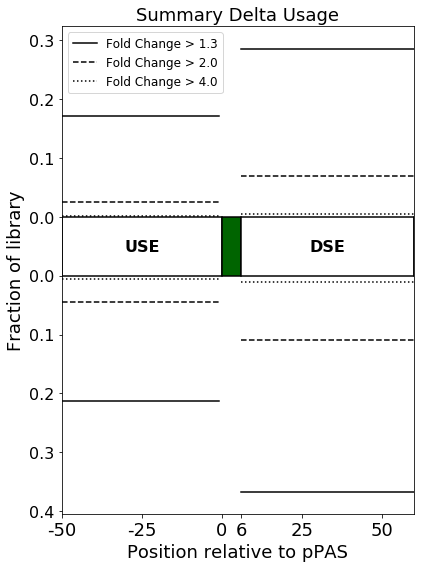

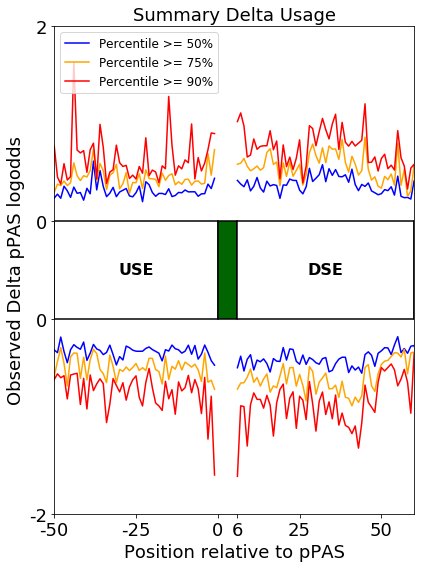

In [11]:
save_figs = False

df_to_use = human_variant_df_filtered.set_index('master_seq')
figsize=(6, 8)

fig_name = None
if save_figs :
    fig_name = 'count_region_all'
plot_count_regions(df_to_use, no_denovo=True, plot_frac=True, count_vs_all=False, annotation_height=0.1, significance_level=0.01, delta_threshes=[0.3, 0.693, 1.3863], delta_linestyles=['-', '--', ':'], figsize=figsize, fig_name=fig_name, plot_start=-50, plot_end=100, fig_dpi=150, pred_column='delta_logodds_pred', true_column='delta_logodds_true', snv_pos_column='snv_pos')


fig_name = None
if save_figs :
    fig_name = 'perc_pos_all'
plot_perc_positions(df_to_use, no_denovo=True, significance_level=0.01, percentiles=[0.5, 0.75, 0.90], percentile_colors=['blue', 'orange', 'red'], figsize=figsize, fig_name=fig_name, plot_start=-50, plot_end=100, fig_dpi=150, pred_column='delta_logodds_pred', true_column='delta_logodds_true', snv_pos_column='snv_pos')


In [12]:
p_thresh = 0.0001
delta_thresh = 0.693
#delta_thresh = 1.386

#Calculate summary variant statistics

#df_to_use = human_variant_df_filtered.copy()
df_to_use = human_variant_df_filtered.query("pooled_proximal_logodds_ref >= -3.0 and pooled_proximal_logodds_ref <= 3.0").copy()

df_to_use['delta_logodds_pred'] = df_to_use['mean_delta_logodds_pred']

delta_pred_thresh = 0.05
df_to_use = df_to_use.query("delta_logodds_pred < -" + str(delta_pred_thresh) + " or delta_logodds_pred > " + str(delta_pred_thresh))


df_gene = df_to_use
df_gene_nopas = df_to_use.query("snv_pos < 50 or snv_pos > 55")

df_gene_signi = df_gene.query("delta_p_val < " + str(p_thresh) + " and (delta_logodds_true < -" + str(delta_thresh) + " or delta_logodds_true > " + str(delta_thresh) + ")")
df_gene_signi_nopas = df_gene_nopas.query("delta_p_val < " + str(p_thresh) + " and (delta_logodds_true < -" + str(delta_thresh) + " or delta_logodds_true > " + str(delta_thresh) + ")")

df_gene_signi_use = df_gene_signi_nopas.query("snv_pos < 50")
df_gene_signi_dse = df_gene_signi_nopas.query("snv_pos > 55")

n_variants = len(df_gene)
n_variants_nopas = len(df_gene_nopas)
n_variants_signi = len(df_gene_signi)
n_variants_signi_nopas = len(df_gene_signi_nopas)

n_variants_use = len(df_gene.query("snv_pos < 50"))
n_variants_use_nopas = len(df_gene_nopas.query("snv_pos < 50"))
n_variants_use_signi = len(df_gene_signi.query("snv_pos < 50"))
n_variants_use_signi_nopas = len(df_gene_signi_nopas.query("snv_pos < 50"))

n_variants_dse = len(df_gene.query("snv_pos > 55"))
n_variants_dse_nopas = len(df_gene_nopas.query("snv_pos > 55"))
n_variants_dse_signi = len(df_gene_signi.query("snv_pos > 55"))
n_variants_dse_signi_nopas = len(df_gene_signi_nopas.query("snv_pos > 55"))

r_val, _ = pearsonr(df_gene['delta_logodds_pred'], df_gene['delta_logodds_true'])
r2 = round(r_val * r_val, 2)
r_val_nopas, _ = pearsonr(df_gene_nopas['delta_logodds_pred'], df_gene_nopas['delta_logodds_true'])
r2_nopas = round(r_val_nopas * r_val_nopas, 2)

r_val, _ = pearsonr(df_gene_signi['delta_logodds_pred'], df_gene_signi['delta_logodds_true'])
r2_signi = round(r_val * r_val, 2)
r_val_nopas, _ = pearsonr(df_gene_signi_nopas['delta_logodds_pred'], df_gene_signi_nopas['delta_logodds_true'])
r2_signi_nopas = round(r_val_nopas * r_val_nopas, 2)

significant_labels = np.zeros(len(df_gene))
significant_labels[(df_gene['delta_p_val'] < p_thresh) & (np.abs(df_gene['delta_logodds_true']) > delta_thresh)] = 1
significant_auc = np.nan
if np.sum(significant_labels) != 0 and np.sum(significant_labels) != len(significant_labels) :
    significant_auc = round(roc_auc_score(significant_labels, np.ravel(np.abs(df_gene['delta_logodds_pred']))), 3)

significant_labels_nopas = np.zeros(len(df_gene_nopas))
significant_labels_nopas[(df_gene_nopas['delta_p_val'] < p_thresh) & (np.abs(df_gene_nopas['delta_logodds_true']) > delta_thresh)] = 1
significant_auc_nopas = np.nan
if np.sum(significant_labels_nopas) != 0 and np.sum(significant_labels_nopas) != len(significant_labels_nopas) :
    significant_auc_nopas = round(roc_auc_score(significant_labels_nopas, np.ravel(np.abs(df_gene_nopas['delta_logodds_pred']))), 3)

direction_labels = np.zeros(len(df_gene_signi))
direction_labels[df_gene_signi['delta_logodds_true'] > 0.0] = 1
direction_auc = np.nan
if np.sum(direction_labels) != 0 and np.sum(direction_labels) != len(direction_labels) :
    direction_auc = round(roc_auc_score(direction_labels, np.ravel(df_gene_signi['delta_logodds_pred'])), 3)

direction_acc = float(len(np.nonzero(np.sign(np.ravel(df_gene_signi['delta_logodds_pred'])) == np.sign(np.ravel(df_gene_signi['delta_logodds_true'])))[0]))
direction_acc /= float(len(df_gene_signi))
direction_acc = round(direction_acc, 3)

direction_labels_nopas = np.zeros(len(df_gene_signi_nopas))
direction_labels_nopas[df_gene_signi_nopas['delta_logodds_true'] > 0.0] = 1
direction_auc_nopas = np.nan
if np.sum(direction_labels_nopas) != 0 and np.sum(direction_labels_nopas) != len(direction_labels_nopas) :
    direction_auc_nopas = round(roc_auc_score(direction_labels_nopas, np.ravel(df_gene_signi_nopas['delta_logodds_pred'])), 3)

direction_acc_nopas = float(len(np.nonzero(np.sign(np.ravel(df_gene_signi_nopas['delta_logodds_pred'])) == np.sign(np.ravel(df_gene_signi_nopas['delta_logodds_true'])))[0]))
direction_acc_nopas /= float(len(df_gene_signi_nopas))
direction_acc_nopas = round(direction_acc_nopas, 3)

direction_labels_use = np.zeros(len(df_gene_signi_use))
direction_labels_use[df_gene_signi_use['delta_logodds_true'] > 0.0] = 1
direction_auc_use = np.nan
if np.sum(direction_labels_use) != 0 and np.sum(direction_labels_use) != len(direction_labels_use) :
    direction_auc_use = round(roc_auc_score(direction_labels_use, np.ravel(df_gene_signi_use['delta_logodds_pred'])), 3)

direction_acc_use = float(len(np.nonzero(np.sign(np.ravel(df_gene_signi_use['delta_logodds_pred'])) == np.sign(np.ravel(df_gene_signi_use['delta_logodds_true'])))[0]))
direction_acc_use /= float(len(df_gene_signi_use))
direction_acc_use = round(direction_acc_use, 3)

direction_labels_dse = np.zeros(len(df_gene_signi_dse))
direction_labels_dse[df_gene_signi_dse['delta_logodds_true'] > 0.0] = 1
direction_auc_dse = np.nan
if np.sum(direction_labels_dse) != 0 and np.sum(direction_labels_dse) != len(direction_labels_dse) :
    direction_auc_dse = round(roc_auc_score(direction_labels_dse, np.ravel(df_gene_signi_dse['delta_logodds_pred'])), 3)

direction_acc_dse = float(len(np.nonzero(np.sign(np.ravel(df_gene_signi_dse['delta_logodds_pred'])) == np.sign(np.ravel(df_gene_signi_dse['delta_logodds_true'])))[0]))
direction_acc_dse /= float(len(df_gene_signi_dse))
direction_acc_dse = round(direction_acc_dse, 3)


print("# UTRs = " + str(len(df_gene['gene'].unique())))
print("# Variants = " + str(n_variants) + " (" + str(n_variants_nopas) + ")")
print("## USE Variants = " + str(n_variants_use) + " (" + str(n_variants_use_nopas) + ")")
print("## DSE Variants = " + str(n_variants_dse) + " (" + str(n_variants_dse_nopas) + ")")
print("# R^2 = " + str(r2) + " (" + str(r2_nopas) + ")")
print("")

print("Significance filter = p < " + str(p_thresh) + ", delta > " + str(delta_thresh))
print("# Significant variants = " + str(n_variants_signi) + " (" + str(n_variants_signi_nopas) + ")")
print("## USE Variants = " + str(n_variants_use_signi) + " (" + str(n_variants_use_signi_nopas) + ")")
print("## DSE Variants = " + str(n_variants_dse_signi) + " (" + str(n_variants_dse_signi_nopas) + ")")
print("# R^2 = " + str(r2_signi) + " (" + str(r2_signi_nopas) + ")")
print("# % Significant = " + str(100. * n_variants_signi / n_variants) + " (" + str(100. * n_variants_signi_nopas / n_variants_nopas) + ")")
print("## % USE Significant = " + str(100. * n_variants_use_signi / n_variants_use) + " (" + str(100. * n_variants_use_signi_nopas / n_variants_use_nopas) + ")")
print("## % DSE Significant = " + str(100. * n_variants_dse_signi / n_variants_dse) + " (" + str(100. * n_variants_dse_signi_nopas / n_variants_dse_nopas) + ")")
print("# Significant? AUC = " + str(significant_auc) + " (" + str(significant_auc_nopas) + ")")
print("# Direction? AUC = " + str(direction_auc) + " (" + str(direction_auc_nopas) + ")")
print("# Direction? Accuracy = " + str(direction_acc) + " (" + str(direction_acc_nopas) + ")")
print("# USE Direction? AUC = " + str(direction_auc_use))
print("# USE Direction? Accuracy = " + str(direction_acc_use))
print("# DSE Direction? AUC = " + str(direction_auc_dse))
print("# DSE Direction? Accuracy = " + str(direction_acc_dse))


# UTRs = 729
# Variants = 6783 (6276)
## USE Variants = 2386 (2386)
## DSE Variants = 3890 (3890)
# R^2 = 0.73 (0.41)

Significance filter = p < 0.0001, delta > 0.693
# Significant variants = 1065 (596)
## USE Variants = 137 (137)
## DSE Variants = 459 (459)
# R^2 = 0.73 (0.62)
# % Significant = 15.701017249004865 (9.496494582536647)
## % USE Significant = 5.7418273260687345 (5.7418273260687345)
## % DSE Significant = 11.79948586118252 (11.79948586118252)
# Significant? AUC = 0.877 (0.792)
# Direction? AUC = 0.983 (0.963)
# Direction? Accuracy = 0.956 (0.923)
# USE Direction? AUC = 0.989
# USE Direction? Accuracy = 0.942
# DSE Direction? AUC = 0.957
# DSE Direction? Accuracy = 0.917


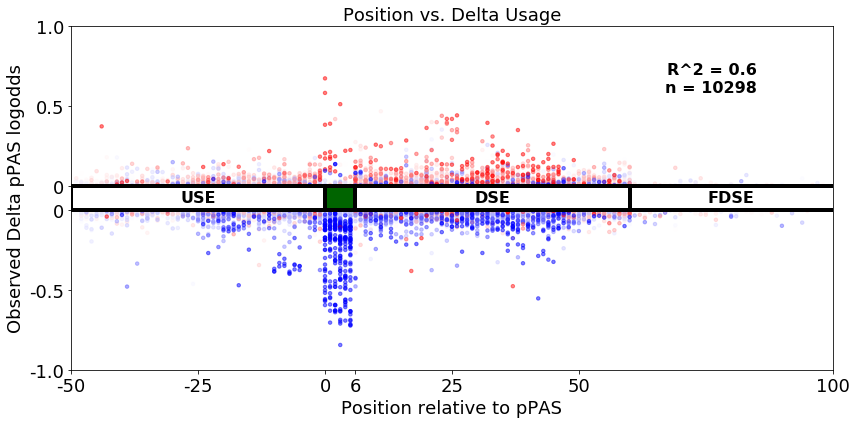

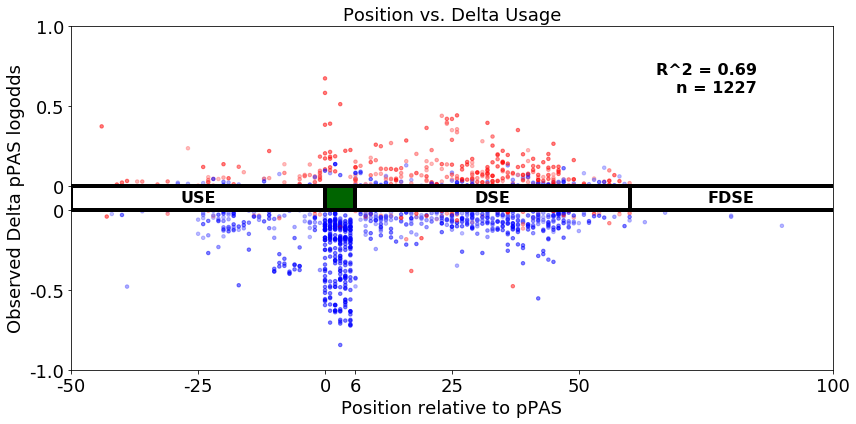

In [13]:
save_figs = False

#All variants
df_to_use = apadb_variant_df_filtered.query("native_usage > 0.0 and native_usage < 1.0")

figsize=(12, 6)

fig_name = None
if save_figs :
    fig_name = 'position_delta_all'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.0, figsize=figsize, fig_name=fig_name, vmin=-0.1, vmax=0.1, fig_dpi=150, annotate=None, pred_column='delta_psi_pred', true_column='delta_psi_true')



#Filtered on prediction >= 0.1 (log)
df_to_use = apadb_variant_df_filtered.query("native_usage > 0.0 and native_usage < 1.0")

fig_name = None
if save_figs :
    fig_name = 'position_delta_all_pred_ge_01'
plot_position_delta_scatter(df_to_use, min_pred_filter=0.05, figsize=figsize, fig_name=fig_name, vmin=-0.1, vmax=0.1, fig_dpi=150, annotate=None, pred_column='delta_psi_pred', true_column='delta_psi_true')


Pathogenic vs. Benign AUC score (based on predicted APA fold change) = 0.936


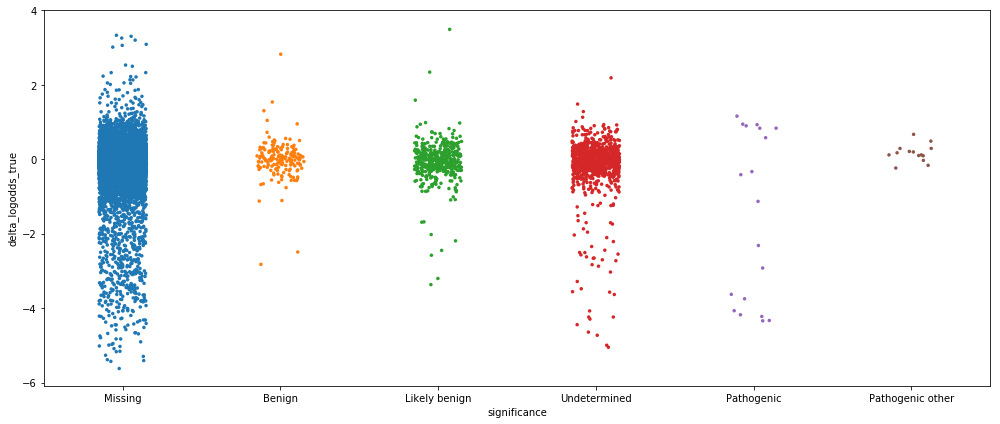

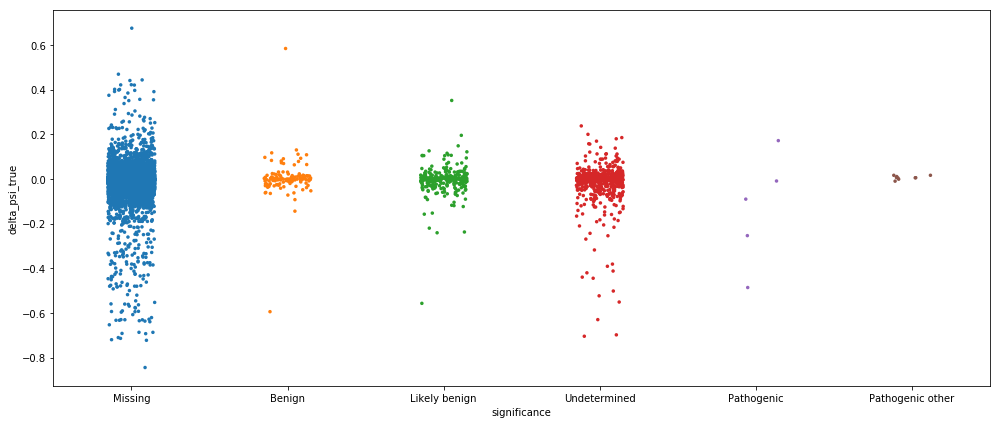

In [14]:

df_to_use = human_variant_df_filtered
df_clinvar = df_to_use.query("variant == 'snv'").copy()
df_clinvar.loc[df_clinvar.significance == 'Likely pathogenic', 'significance'] = 'Pathogenic'

#Re-annotate variants that are pathogenic for other reasons than APA
df_clinvar.loc[df_clinvar.gene == 'SPRTN.10', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'RMRP.2', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'RNU4ATAC.4', 'significance'] = 'Pathogenic UTR5'
df_clinvar.loc[df_clinvar.gene == 'RPL11.3', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'SERPINA1.5', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'TMEM107.4', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'HBB.3', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'HBB.4', 'significance'] = 'Pathogenic other'


patho_vs_benign_labels = []
patho_vs_benign_delta_pred = []
for index, row in df_clinvar.iterrows() :
    if row['significance'] == 'Benign' :
        patho_vs_benign_labels.append(0)
    elif row['significance'] == 'Pathogenic' :
        patho_vs_benign_labels.append(1)
    else :
        continue
    
    patho_vs_benign_delta_pred.append(row['delta_logodds_pred'])

patho_vs_benign_pred_auc = roc_auc_score(np.ravel(patho_vs_benign_labels), np.abs(np.ravel(patho_vs_benign_delta_pred)))
print('Pathogenic vs. Benign AUC score (based on predicted APA fold change) = ' + str(round(patho_vs_benign_pred_auc, 3)))

f = plt.figure(figsize=(14, 6))
sns.stripplot(x="significance", y="delta_logodds_true", data=df_clinvar, jitter=0.15, size=3.5, order=['Missing', 'Benign', 'Likely benign', 'Undetermined', 'Pathogenic', 'Pathogenic other'])

plt.tight_layout()
plt.show()


#APADB-scaled dPSIs
df_to_use = apadb_variant_df_filtered.copy()
df_clinvar = df_to_use.query("variant == 'snv' and native_usage > 0.01 and native_usage < 0.99").copy()
df_clinvar.loc[df_clinvar.significance == 'Likely pathogenic', 'significance'] = 'Pathogenic'

#Re-annotate variants that are pathogenic for other reasons than APA
df_clinvar.loc[df_clinvar.gene == 'SPRTN.10', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'RMRP.2', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'RNU4ATAC.4', 'significance'] = 'Pathogenic UTR5'
df_clinvar.loc[df_clinvar.gene == 'RPL11.3', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'SERPINA1.5', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'TMEM107.4', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'HBB.3', 'significance'] = 'Pathogenic other'
df_clinvar.loc[df_clinvar.gene == 'HBB.4', 'significance'] = 'Pathogenic other'


f = plt.figure(figsize=(14, 6))
sns.stripplot(x="significance", y="delta_psi_true", data=df_clinvar, jitter=0.15, size=3.5, order=['Missing', 'Benign', 'Likely benign', 'Undetermined', 'Pathogenic', 'Pathogenic other'])

plt.tight_layout()
plt.show()



